In [8]:
!pip install -Uqq fastai duckduckgo_search


In [6]:
from fastcore.all import *
import time
import json

def search_images(term, max_images=200):
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')    
    headers = dict( referer='https://duckduckgo.com/' )
    urls,data = set(),{'next':1}
    while len(urls)<max_images and 'next' in data:
        res = urlread(requestUrl, data=params, headers=headers)
        data = json.loads(res) if res else {}
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = url + data['next']
        time.sleep(0.2)
    return L(urls)[:max_images]

urls = search_images('bird photos', max_images=1)
urls[0]


# dir(Image)

'https://www.hdwallpapers.in/download/yellow_black_birds_with_open_mouth_are_on_yellow_flowers_branch_hd_birds-1920x1080.jpg'

In [13]:
from fastcore.all import *
import time
import json

def search_sourcecode(extension, max_items=100):
    search_engine = 'https://duckduckgo.com/'
    # query = 'site:raw.githubusercontent.com {extension}'.format(extension=extension)
    query = 'python'
    result = urlread(search_engine, data={'q': query})
    searchObj = re.search(r'vqd=([\d-]+)\&', result)
    requestUrl = search_engine + 'i.js'
    params = dict(l='us-en', o='json', q=query, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')    
    headers = dict( referer=search_engine )
    urls = set()
    data = {'next':1}

    result = urlread(requestUrl, data=params, headers=headers)
    data = json.loads(result) if result else {}
    return data
    urls.update(L(data['results']).itemgot('image'))
    requestUrl = search_engine + data['next']
    
    while False and len(urls)<max_items and 'next' in data:
        result = urlread(requestUrl, data=params, headers=headers)
        data = json.loads(result) if result else {}
        urls.update(L(data['results']).itemgot('image'))
        requestUrl = search_engine + data['next']
        time.sleep(0.2)
    goodUrls = [u for u in urls if u.endswith(extension)]
    return L(urls)[:max_items]

# urls = search_sourcecode('java', 1)
# urls

{'ads': None,
 'next': 'i.js?q=python&o=json&p=1&s=100&u=bing&f=,,,&l=us-en',
 'query': 'python',
 'queryEncoded': 'python',
 'response_type': 'places',
 'results': [{'height': 2856,
   'image': 'https://lp-cms-production.imgix.net/news/2016/01/Burmese-Python-U.S.-Fish-Wildlife-Service.jpg?auto=format&fit=crop&sharp=10&vib=20&ixlib=react-8.6.4&w=850&q=20&dpr=5',
   'source': 'Bing',
   'thumbnail': 'https://tse4.mm.bing.net/th?id=OIP.vwbKUT1rbmv_-WVda8OTgQHaE-&pid=Api',
   'title': 'Everglades snake hunt to cull Burmese python population - Lonely Planet',
   'url': 'https://www.lonelyplanet.com/articles/everglades-snake-hunt-to-cull-burmese-python-population',
   'width': 4250},
  {'height': 2844,
   'image': 'https://miro.medium.com/max/7536/1*l7b0FEFfKi4G3fzWgNAdHQ.jpeg',
   'source': 'Bing',
   'thumbnail': 'https://tse1.mm.bing.net/th?id=OIP._clhO2NSs6ylcT2uM8kYMAHaFl&pid=Api',
   'title': 'Burmese python hatchlings on the move - Environmental Science ...',
   'url': 'https://mediu

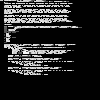

In [13]:
import PIL
#from fastai import open_image

def char_to_pixel(c):
    if c == ' ':
        return 1
    return ord(c) * 2 - 1

def text_to_image(text, img_file):
    width = 100
    lines_processed = 0
    raw = []
    for line in text.splitlines():
        padded_line = line[:width].ljust(width, ' ')
        pixels = [char_to_pixel(c) for c in padded_line]
        raw.extend(pixels)
        lines_processed += 1
    blank_line = [1] * width
    while lines_processed < width:
        raw.extend(blank_line)
        lines_processed += 1
    # padded_text
    # return raw
    im = PIL.Image.frombytes('L', (width, width), bytes(raw))
    im.save(img_file, 'png')
    

# test
import inspect
import difflib
source = inspect.getsource(difflib.context_diff)
#source = inspect.getsource(inspect.getsource)
text_to_image(source, 'python.png')

from IPython.display import Image as show_image
from fastai.vision.all import *
Image.open('python.png').to_thumb(400, 400)